<a href="https://colab.research.google.com/github/DineshSiddhartha/ML_Assignment_2/blob/main/Another_copy_of_Task2_Q1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

1.Image Reconstruction - Choose any image you like. Use Random Fourier Features (RFF) and Linear Regression to learn the mapping from the image coordinates
(
X
,
Y
)
 to the pixel colors
(
R
,
G
,
B
)
. Here,
(
X
,
Y
)
 represents the coordinates of the pixels, and
(
R
,
G
,
B
)
 represents the color values at those coordinates. Display both the original image and the reconstructed image. Also, calculate and report the Root Mean Squared Error (MSE) and Peak Signal-to-Noise Ratio (PSNR) between the original and reconstructed images. [1.5 Mark]

In [ ]:
import torch
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

import numpy as np
import pandas as pd
import torch.nn as nn
import torch.nn.functional as F

# Remove all the warnings
import warnings
warnings.filterwarnings('ignore')

# Set env CUDA_LAUNCH_BLOCKING=1
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Retina display
%config InlineBackend.figure_format = 'retina'

try:
    from einops import rearrange
except ImportError:
    %pip install einops
    from einops import rearrange

In [ ]:
if os.path.exists('dog.jpg'):
    print('dog.jpg exists')
else:
    !wget https://cdn.britannica.com/79/232779-050-6B0411D7/German-Shepherd-dog-Alsatian.jpg -O dog.jpg

dog.jpg exists


torch.Size([3, 1144, 1600])


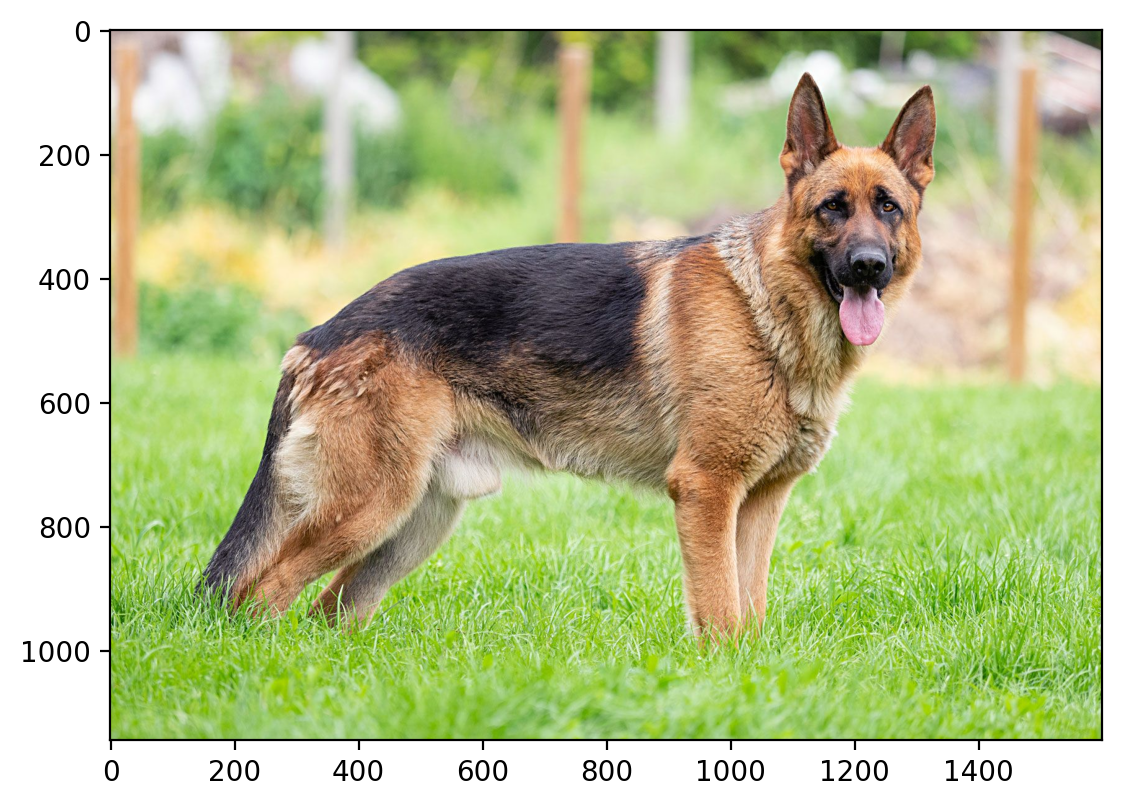

In [ ]:
img = torchvision.io.read_image("dog.jpg")
print(img.shape)
plt.imshow(rearrange(img, 'c h w -> h w c').numpy())

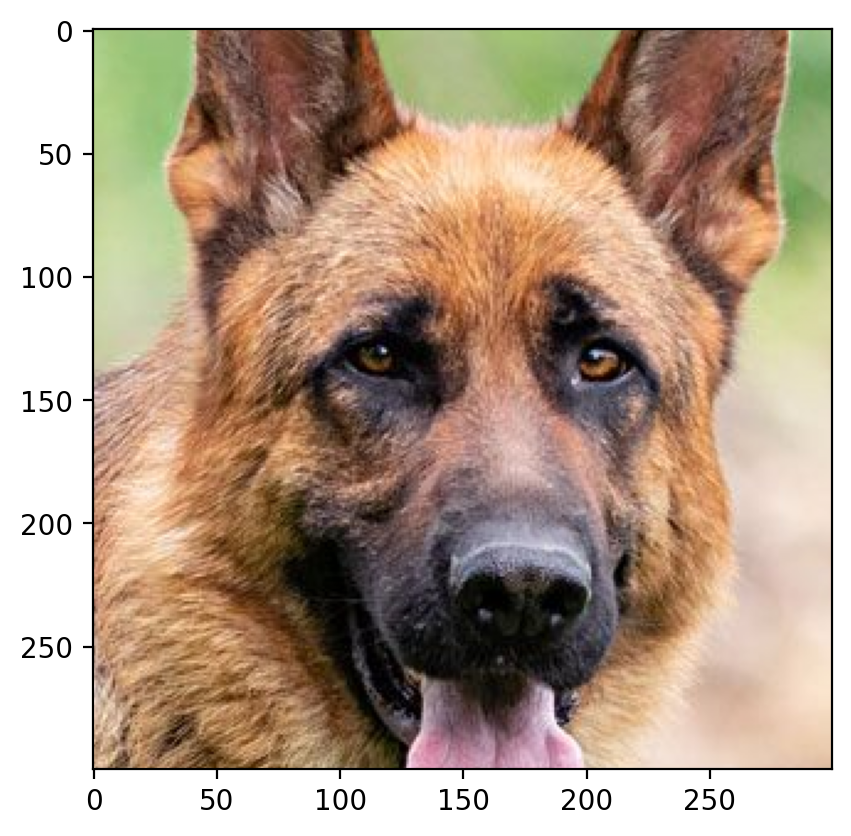

In [ ]:
from sklearn import preprocessing

scaler_img = preprocessing.MinMaxScaler().fit(img.reshape(-1, 1))
img_scaled = scaler_img.transform(img.reshape(-1, 1)).reshape(img.shape)
img_scaled.shape

img_scaled = torch.tensor(img_scaled)
img_scaled = img_scaled.to(device)
crop = torchvision.transforms.functional.crop(img_scaled.cpu(), 150, 1050, 300, 300)
plt.imshow(rearrange(crop, 'c h w -> h w c').cpu().numpy())

In [ ]:
crop = crop.to(device)
num_channels, height, width = crop.shape
print(num_channels, height, width)

3 300 300


In [ ]:
def create_coordinate_map(img):
    """
    img: torch.Tensor of shape (num_channels, height, width)

    return: tuple of torch.Tensor of shape (height * width, 2) and torch.Tensor of shape (height * width, num_channels)
    """

    num_channels, height, width = img.shape

    # Create a 2D grid of (x,y) coordinates (h, w)
    # width values change faster than height values
    w_coords = torch.arange(width).repeat(height, 1)
    h_coords = torch.arange(height).repeat(width, 1).t()
    w_coords = w_coords.reshape(-1)
    h_coords = h_coords.reshape(-1)

    # Combine the x and y coordinates into a single tensor
    X = torch.stack([h_coords, w_coords], dim=1).float()

    # Move X to GPU if available
    X = X.to(device)

    # Reshape the image to (h * w, num_channels)
    Y = rearrange(img, 'c h w -> (h w) c').float()
    return X, Y

In [ ]:
dog_X, dog_Y = create_coordinate_map(crop)

dog_X.shape, dog_Y.shape

(torch.Size([90000, 2]), torch.Size([90000, 3]))

In [ ]:
# MinMaxScaler from -1 to 1
scaler_X = preprocessing.MinMaxScaler(feature_range=(-1, 1)).fit(dog_X.cpu())

# Scale the X coordinates
dog_X_scaled = scaler_X.transform(dog_X.cpu())

# Move the scaled X coordinates to the GPU
dog_X_scaled = torch.tensor(dog_X_scaled).to(device)

# Set to dtype float32
dog_X_scaled = dog_X_scaled.float()

In [ ]:
class LinearModel(nn.Module):
    def __init__(self, in_features, out_features):
        super(LinearModel, self).__init__()
        self.linear = nn.Linear(in_features, out_features)

    def forward(self, x):
        return self.linear(x)
net = LinearModel(2, 3)
net.to(device)
def train(net, lr, X, Y, epochs, verbose=True):
    """
    net: torch.nn.Module
    lr: float
    X: torch.Tensor of shape (num_samples, 2)
    Y: torch.Tensor of shape (num_samples, 3)
    """

    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(net.parameters(), lr=lr)
    for epoch in range(epochs):
        optimizer.zero_grad()
        outputs = net(X)


        loss = criterion(outputs, Y)
        loss.backward()
        optimizer.step()
        if verbose and epoch % 100 == 0:
            print(f"Epoch {epoch} loss: {loss.item():.6f}")
    return loss.item()

In [ ]:
# create RFF features
def create_rff_features(X, num_features, sigma):
    from sklearn.kernel_approximation import RBFSampler
    rff = RBFSampler(n_components=num_features, gamma=1/(2 * sigma**2))
    X = X.cpu().numpy()
    X = rff.fit_transform(X)
    return torch.tensor(X, dtype=torch.float32).to(device)


In [ ]:
X_rff = create_rff_features(dog_X_scaled, 5000, 0.008)

In [ ]:
net = LinearModel(X_rff.shape[1], 3)
net.to(device)

train(net, 0.05, X_rff, dog_Y, 2500)

Epoch 0 loss: 0.346544
Epoch 100 loss: 0.024691
Epoch 200 loss: 0.019896
Epoch 300 loss: 0.018285
Epoch 400 loss: 0.017683
Epoch 500 loss: 0.017384
Epoch 600 loss: 0.017198
Epoch 700 loss: 0.017075
Epoch 800 loss: 0.016996
Epoch 900 loss: 0.016946
Epoch 1000 loss: 0.016916
Epoch 1100 loss: 0.016900
Epoch 1200 loss: 0.016890
Epoch 1300 loss: 0.016886
Epoch 1400 loss: 0.016883
Epoch 1500 loss: 0.016882
Epoch 1600 loss: 0.016882
Epoch 1700 loss: 0.016882
Epoch 1800 loss: 0.016882
Epoch 1900 loss: 0.016882
Epoch 2000 loss: 0.016881
Epoch 2100 loss: 0.016882
Epoch 2200 loss: 0.016882
Epoch 2300 loss: 0.016882
Epoch 2400 loss: 0.016881


0.016881415620446205

In [ ]:
def plot_reconstructed_and_original_image(original_img, net, X, title=""):
    """
    net: torch.nn.Moduled
    X: torch.Tensor of shape (num_samples, 2)
    Y: torch.Tensor of shape (num_samples, 3)
    """
    num_channels, height, width = original_img.shape
    net.eval()
    with torch.no_grad():
        outputs = net(X)
        outputs = outputs.reshape(height, width, num_channels)
        #outputs = outputs.permute(1, 2, 0)
    fig = plt.figure(figsize=(6, 4))
    gs = gridspec.GridSpec(1, 2, width_ratios=[1, 1])

    ax0 = plt.subplot(gs[0])
    ax1 = plt.subplot(gs[1])

    ax0.imshow(outputs.cpu())
    ax0.set_title("Reconstructed Image")


    ax1.imshow(original_img.cpu().permute(1, 2, 0))
    ax1.set_title("Original Image")

    for a in [ax0, ax1]:
        a.axis("off")


    fig.suptitle(title, y=0.9)
    plt.tight_layout()


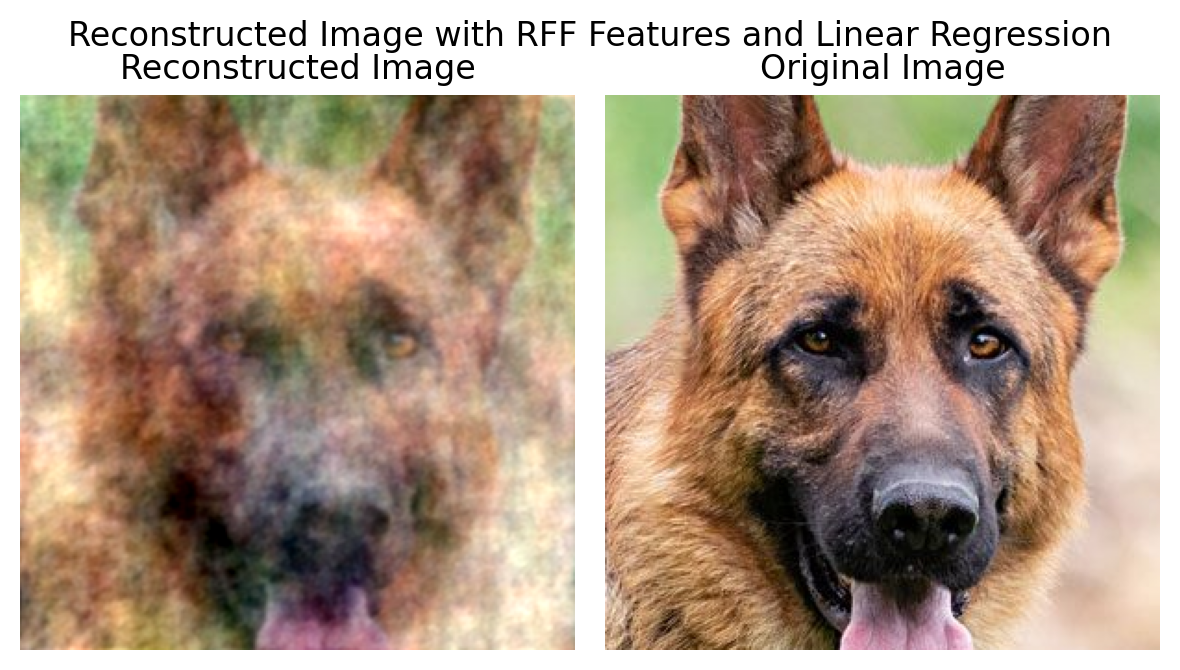

In [ ]:
plot_reconstructed_and_original_image(crop, net, X_rff, title="Reconstructed Image with RFF Features and Linear Regression")

In [ ]:
def RMSE(original,reconstructed):
    mse = np.mean((original - reconstructed) ** 2)
    rmse = np.sqrt(mse)
    return rmse

with torch.no_grad():
    reconstructed_output = net(X_rff).reshape(crop.shape)

rmse = RMSE(crop.cpu().numpy(), reconstructed_output.cpu().numpy())
print("Root Mean Squared Error is",rmse)

def calculate_psnr(original, reconstructed,rmse):

    max_pixel_value = 255.0
    psnr = 20 * np.log10(max_pixel_value / rmse) if rmse != 0 else float('inf')
    return psnr

psnr = calculate_psnr(crop.cpu().numpy(), reconstructed_output.cpu().numpy(),rmse)
print("Peak Signal-to-Noise Ratio is",psnr)

Root Mean Squared Error is 0.3303554478361906
Peak Signal-to-Noise Ratio is 57.75117414706451
